In [1]:
import os
import shutil
import glob
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import splitfolders

import tensorflow as tf

tf.__version__

'2.5.0'

# Split data

In [2]:
should_prepare_data = True

train_sequential = True

train_residual = False

In [3]:
def prepare_data():
    
    dirpaths = []
    class_names = []
    
    # generate list with roots for folders
    for dirpath, folder, _ in os.walk('./data/flowers/'):
        dirpaths.append(dirpath)
        class_names.append(folder)
    
    class_names = class_names[0]
        
    j = 0
    
    # loop through roots of image folders
    for dirpath in dirpaths[1:]:

        dst_dir = './data/input_flowers'

        if not os.path.exists(dst_dir):
            os.mkdir(dst_dir)

        i = 1  # no. of image

        for jpg_file in glob.iglob(os.path.join(dirpath, '*.jpg')):

            img_path = os.path.join(dst_dir, class_names[j])

            if not os.path.exists(img_path):
                os.mkdir(img_path)

            new_name = f'{class_names[j]}/{j}_{i}.jpg'

            shutil.copy(jpg_file, os.path.join(dst_dir, new_name))

            i += 1

        j += 1

    # split images to train/val/test folders
    splitfolders.ratio('./data/input_flowers', output='./data/output_flowers', seed=1337, ratio=(.7, .15, .15))
    
    return class_names

In [4]:
if should_prepare_data:
    prepare_data()

Copying files: 4317 files [00:00, 7626.58 files/s]


# Define train/val/test sets

In [5]:
batch_size = 32
img_height = 240
img_width = 240

train_dir = './data/output_flowers/train/'
val_dir = './data/output_flowers/val/'
test_dir = './data/output_flowers/test/'

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )

Found 3019 files belonging to 5 classes.


In [7]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 644 files belonging to 5 classes.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 654 files belonging to 5 classes.


In [9]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

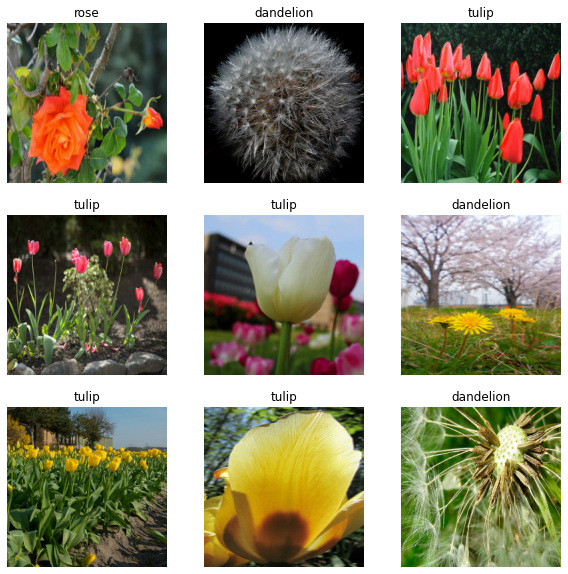

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Data Augemntation

In [50]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

Found 3019 images belonging to 5 classes.
Found 644 images belonging to 5 classes.


# Deep learning model

In [51]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [61]:
def get_model(num_classes, dropout_rate=0.5):
    model = tf.keras.Sequential([

        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        
        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),      
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),      
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),          

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes)  
    ])
    
    return model

model = get_model(5)
    
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 240, 240, 32)      896       
_________________________________________________________________
activation_60 (Activation)   (None, 240, 240, 32)      0         
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 120, 120, 32)      9248      
_________________________________________________________________
activation_61 (Activation)   (None, 120, 120, 32)      0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 60, 60, 32)      

In [62]:
epochs = 20

if train_sequential:
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs
    )

Epoch 1/20
95/95 [==============================] - 31s 321ms/step - loss: 1.4676 - accuracy: 0.3604 - val_loss: 1.2617 - val_accuracy: 0.4410
Epoch 2/20
95/95 [==============================] - 30s 316ms/step - loss: 1.2043 - accuracy: 0.4823 - val_loss: 1.1245 - val_accuracy: 0.5373
Epoch 3/20
95/95 [==============================] - 30s 316ms/step - loss: 1.1113 - accuracy: 0.5528 - val_loss: 0.9520 - val_accuracy: 0.6289
Epoch 4/20
95/95 [==============================] - 30s 316ms/step - loss: 1.0259 - accuracy: 0.5972 - val_loss: 0.9280 - val_accuracy: 0.6289
Epoch 5/20
95/95 [==============================] - 30s 314ms/step - loss: 0.9619 - accuracy: 0.6356 - val_loss: 0.9862 - val_accuracy: 0.6056
Epoch 6/20
95/95 [==============================] - 30s 315ms/step - loss: 0.9255 - accuracy: 0.6515 - val_loss: 0.7958 - val_accuracy: 0.6801
Epoch 7/20
95/95 [==============================] - 30s 316ms/step - loss: 0.8969 - accuracy: 0.6578 - val_loss: 0.9304 - val_accuracy: 0.6429

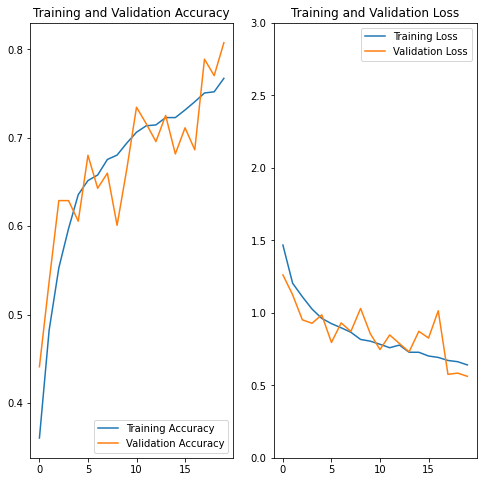

In [63]:
if train_sequential:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylim((0, 3))
    plt.show()

In [64]:
if train_sequential:
    model.evaluate(test_ds)

21/21 [==============================] - 1s 24ms/step - loss: 0.5649 - accuracy: 0.7875


## Residual model

In [ ]:
def conv2d_block(input_tensor, n_filters):
    
    x = input_tensor
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.MaxPooling2D()(x)
    
#     x = layers.Dropout(0.3)(x)
    
    return x
    

In [ ]:
def residual_block(input_tensor, n_filters):
    
    block_1 = conv2d_block(input_tensor, n_filters=n_filters)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(block_1)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.add([block_1, x])
    
    return x

In [ ]:
def get_res_model(num_classes, filters_conv2d_blocks):
    
    inputs = layers.Input(shape=(img_height, img_width, 3))
    
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    
    for num_filters in filters_conv2d_blocks:
        x = residual_block(input_tensor=x, n_filters=num_filters)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu', kernel_regularizer='l2')(x)
    outputs = layers.Dense(num_classes)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="residual_model")
    
    return model

In [ ]:
model_res = get_res_model(5, [32, 64, 64, 64])
model_res.summary()

In [ ]:
tf.keras.utils.plot_model(model_res, "res_model.png", show_shapes=True)


In [ ]:
model_res.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20

if train_residual:
    
    history_res = model_res.fit(
            train_ds,
            validation_data=validation_ds,
            epochs=epochs
    )

In [ ]:
def display_plots(history_var):
    acc = history_var.history['accuracy']
    val_acc = history_var.history['val_accuracy']

    loss = history_var.history['loss']
    val_loss = history_var.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylim((0, 2))
    plt.show()
    
    
if train_residual:
    display_plots(history_res)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
y_true = test_ds[1]
y_pred = model_res.predict(test_ds)